## Tutorial: cell type deconvolution for simulated dataset

In [1]:
import torch
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
# from .util import permutation
import os
import random
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
import sys
sys.path.insert(1, '/home/nas2/biod/myy/project/CLPLS_package')
from CLPLS.util import *
from CLPLS.process import process_sc, process_st
from CLPLS.train import train

/tmp/ipykernel_3873502/3842045630.py:15: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  from scipy.sparse.csc import csc_matrix
/tmp/ipykernel_3873502/3842045630.py:16: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  from scipy.sparse.csr import csr_matrix


In [2]:
epochs = 400
dim_input = 320 #input dimension
beta = 0.1 #positive loss hyperparam
random_seed = 11
torch.manual_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)

#read data
st_adata = sc.read_h5ad('/home/nas2/biod/myy/project/CLPLS_package/data/simulated_data/adata_st.h5ad')
sadj, graph_neigh, label_CSL = process_st(st_adata)

sc_adata = sc.read_h5ad('/home/nas2/biod/myy/project/CLPLS_package/data/simulated_data/adata_rna.h5ad')
ctype_lab, fadj = process_sc(sc_adata, "cell_subclass")

embedding_st, embedding_sc = train(dim_input=dim_input,hidden_channels=128,dim_output=50,nclass=7,st_adata=st_adata,graph_neigh=graph_neigh,spatial_graph=sadj,sc_adata=sc_adata,snn=fadj,ctype_lab=ctype_lab,label_CSL=label_CSL,epochs=epochs,beta=beta)

Graph with 490 nodes and 1398 edges
[0 0 0 0 1 1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4 4 4 4 4 5 5 5 6 6]
[  2  13  14 ... 473 476 476]
tensor([[  2,  13,  14,  ..., 298, 330, 400],
        [  0,   0,   0,  ..., 489, 489, 489]])
tensor([[    0,     0,     0,  ..., 10259, 10259, 10259],
        [   26,   525,   530,  ...,  6929,  6937,  7701]])
Begin to train ST data...


100%|██████████| 400/400 [00:35<00:00, 11.20it/s]

Optimization finished for ST data!
Training complete!
Embedding is saved 


In [3]:
cell_subclass = ['L2/3 IT', 'L4', 'L5 IT', 'L5 PT', 'L6b', 'L6 CT', 'L6 IT']
list = []
for j in range(7):
    indexes = []
    for i in range(len(sc_adata.obs['cell_subclass'])):
        if sc_adata.obs['cell_subclass'][i] == cell_subclass[j]:
            indexes.append(i)
    selected_rows = embedding_sc[indexes]
    list.append(np.mean(selected_rows,axis=0))
list = np.array(list)
pls2 = PLSRegression(n_components=7)
pls2.fit(list.T, embedding_st.T)
pls2_u = pls2.x_weights_
pls2_v = pls2.y_weights_

scaled_matrix = (pls2.coef_ - np.min(pls2.coef_, axis=0)) / (np.max(pls2.coef_, axis=0) - np.min(pls2.coef_, axis=0))
dividesum_matrix = scaled_matrix/scaled_matrix.sum(axis=0)
names = ['L2/3 IT', 'L4', 'L5 IT', 'L5 PT', 'L6b', 'L6 CT', 'L6 IT']
proportion_pls2 = pd.DataFrame(np.array(dividesum_matrix).T,columns=names)


/home/moyuanyuan/anaconda3/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


[<Axes: title={'center': 'L2/3 IT'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'L4'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'L5 IT'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'L5 PT'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'L6b'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'L6 CT'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'L6 IT'}, xlabel='spatial1', ylabel='spatial2'>]

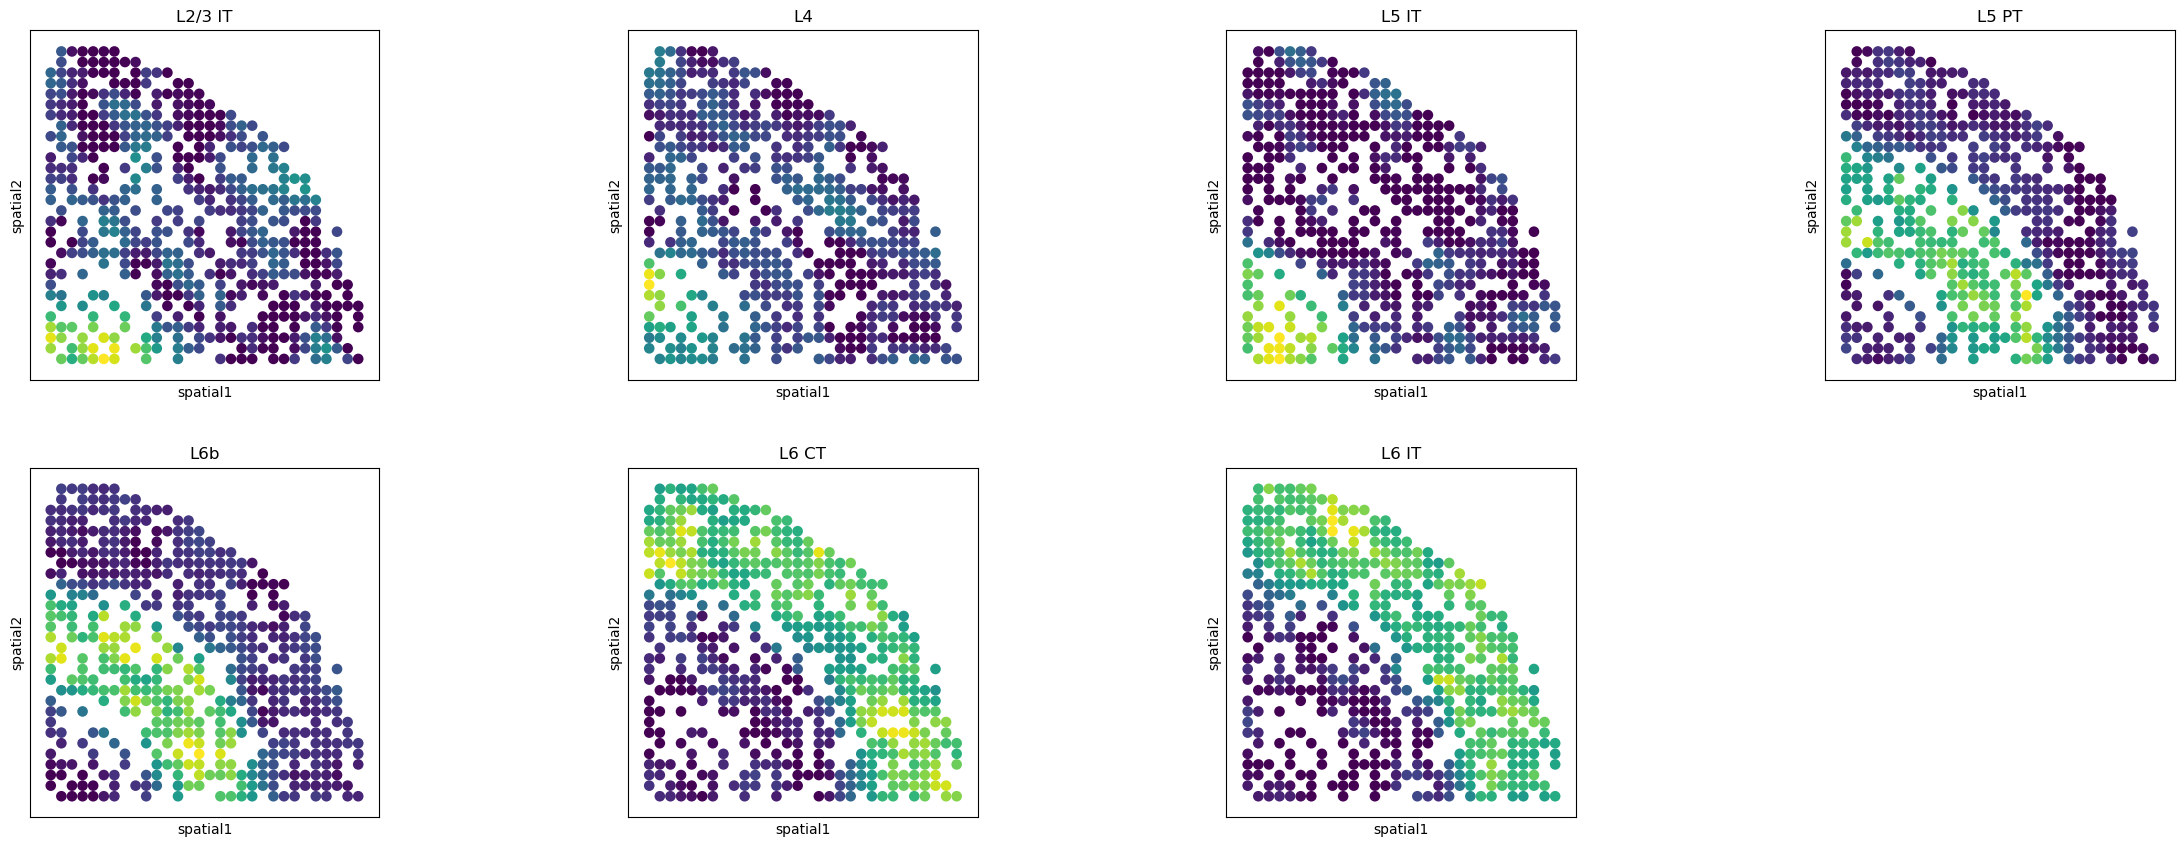

In [4]:
import matplotlib.pyplot as plt
adata_st1 = st_adata.copy()
# 将y坐标取反一次
adata_st1.obsm['spatial'][:, 1] = -adata_st1.obsm['spatial'][:, 1]
for i in range(7):
    adata_st1.obs[proportion_pls2.columns.values[i]] = proportion_pls2.values[:,i]
sc.pl.spatial(adata_st1, spot_size=1, color=proportion_pls2.columns.values,colorbar_loc=None,show=False)